In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import os
import investpy

In [2]:
stocknam=['XOM','MSFT', 'CAT','DIS','PFE','SBUX','AMD','T','AAPL','GE']

stock=investpy.get_stock_historical_data(stock=stocknam[0],country='united states', from_date='01/01/2015', to_date='01/01/2020')['Close']
stock=pd.DataFrame(stock)
for s in range(1,len(stocknam)):
    try:
        st=investpy.get_stock_historical_data(stock=stocknam[s],country='united states', from_date='01/01/2015', to_date='01/01/2020')['Close']
        stock=pd.concat([stock,pd.Series(st)],axis=1)
    except RuntimeError:
        print(stocknam[s])

sp=investpy.indices.get_index_historical_data(index='S&P 500',country='united states', from_date='01/01/2015', to_date='01/01/2020')['Close']
stock=pd.concat([stock,sp],axis=1)
stock.columns=['XOM','MSFT', 'CAT','DIS','PFE','SBUX','AMD','T','AAPL','GE','S&P 500']

stock.to_excel('data_stocks.xlsx')

In [3]:
stock.head(3)

,XOM,MSFT,CAT,DIS,PFE,SBUX,AMD,T,AAPL,GE,S&P 500
Date,,,,,,,,,,,
2015-01-02,92.83,46.76,91.88,93.75,31.33,40.72,2.69,33.87,109.33,25.06,2058.20
2015-01-05,90.29,46.33,87.03,92.38,31.16,39.94,2.66,33.55,106.25,24.60,2020.58
2015-01-06,89.81,45.65,86.47,91.89,31.42,39.62,2.63,33.60,106.26,24.07,2002.61


In [4]:
# Params
# n - # of stocks to consider
# rf - risk free
# num_ports - # of portfolios to consturct --> the more we construct the harder to compute EF
n = 3
rf = 0.02249#risk-free 30Y treasuries
num_ports = 50

In [5]:
data=stock.iloc[:,:-8]
data.head(3)

,XOM,MSFT,CAT
Date,,,
2015-01-02,92.83,46.76,91.88
2015-01-05,90.29,46.33,87.03
2015-01-06,89.81,45.65,86.47


In [6]:
expectedreturns=[]
variance_=[]
for i in range(np.array(data).shape[1]):
    expectedreturns.append(data.iloc[:,i].mean())
    variance_.append(data.iloc[:,i].var())

In [7]:
exp_var=pd.DataFrame([expectedreturns,variance_])
u=['exp','var']
exp_var=pd.concat([exp_var,pd.Series(u)],axis=1)
exp_var.set_index(exp_var.iloc[:,-1], inplace = True, append = True, drop = True)
exp_var.columns=['XOM','MSFT', 'CAT','to_del']
exp_var=exp_var.drop(columns=['to_del'])
exp_var

,,XOM,MSFT,CAT
,0,,,
0,exp,80.920032,81.042375,109.493140
1,var,36.033473,1026.855188,876.152356


In [8]:
log_ret = np.log(data/data.shift(1))
market_ret = np.log(stock['S&P 500']/stock['S&P 500'].shift(1))

In [9]:
np.random.seed(42)
all_weights = np.zeros((num_ports, n))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(n))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

In [10]:
#CML equation 0.02249 + 0.7049934653877946*portfolio st deviation
x_cml = np.linspace(0, max(vol_arr))
slope = (max_sr_ret - rf) / (max_sr_vol)
y_cml = list(map(lambda x: rf + slope * x, x_cml))

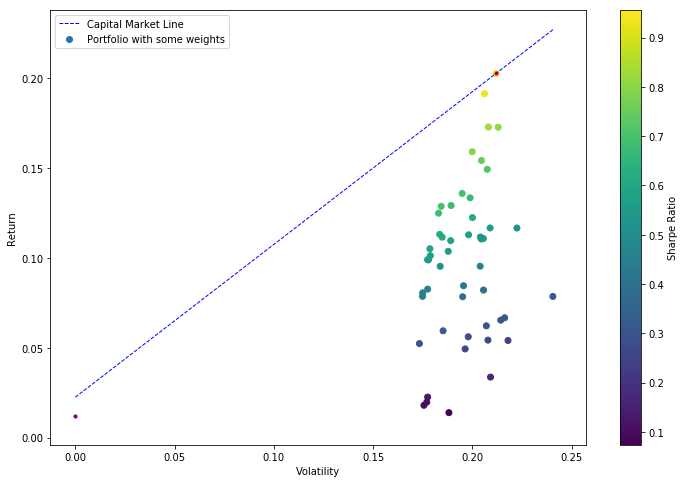

In [11]:
x=[0 ,max_sr_vol]
y=[1.19/100, max_sr_ret  ]

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', label = 'Portfolio with some weights')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=10) # red dot
plt.scatter(0, 1.19/100,c='purple', s=10) # red dot
plt.plot(x_cml, y_cml, linestyle='--', color='b', linewidth=1, label = 'Capital Market Line')
plt.legend()
plt.plot()
plt.show()

In [12]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [13]:
frontier_y = np.linspace(0, 0.3, 200)
cons = ({'type':'eq', 'fun': check_sum })
bounds = ((0,1),)*n
init_guess = list(map(lambda x: 1/n, range(n)))
opt_results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints=cons)
print(opt_results)

     fun: -1.0459392488266948
     jac: array([0.56300667, 0.        , 0.1602588 ])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0., 1., 0.])


In [36]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])


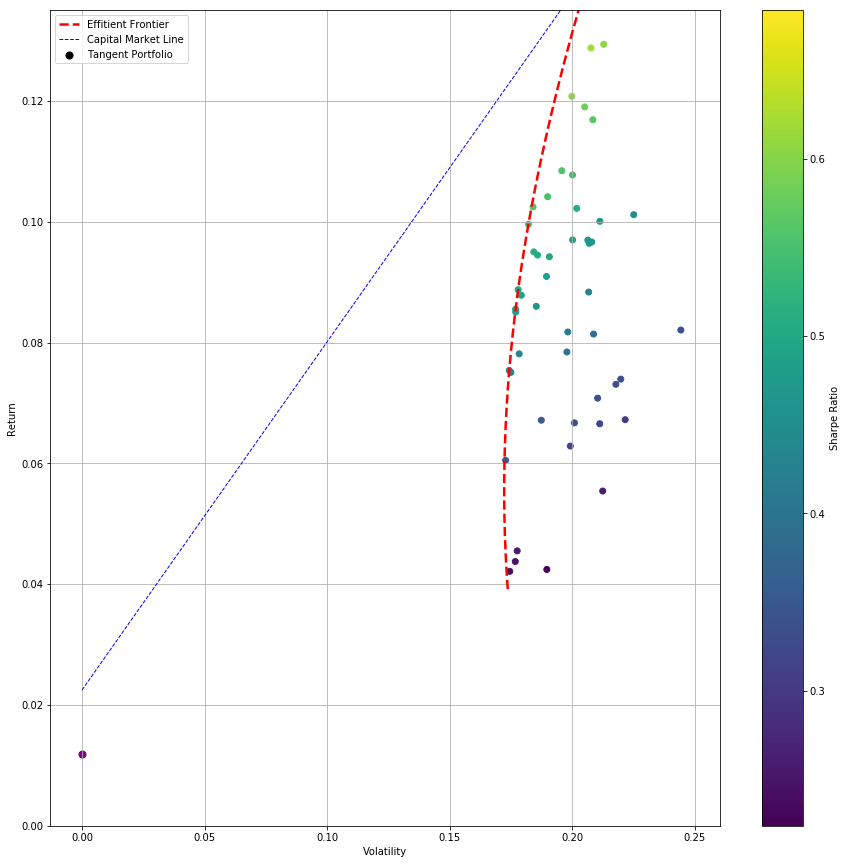

In [37]:
plt.figure(figsize=(15,15))
plt.grid(linestyle = '-')
plt.ylim([0,0.135])
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x[26:],frontier_y[26:], 'r--', linewidth=2.5, label = 'Effitient Frontier')
#plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', label = 'Portfolio with some weights')
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=50, label = 'Tangent Portfolio') # red dot
plt.scatter(0, 1.19/100,c='purple', s=50) # red dot
plt.plot(x_cml, y_cml, linestyle='--', color='b', linewidth=1, label = 'Capital Market Line')
plt.legend()
plt.show()

In [14]:
total_return=pd.concat([log_ret,pd.Series(market_ret)],axis=1)
total_return.head(3)

,XOM,MSFT,CAT,S&P 500
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.027743,-0.009238,-0.054230,-0.018447
2015-01-06,-0.005330,-0.014786,-0.006455,-0.008933


In [15]:
covarian=list()
beta=list()
MRP=list()
for i in list(data.columns):
    covarian.append(total_return.cov().loc['S&P 500',i])
marketvar=total_return['S&P 500'].var()
for j in covarian:
    beta.append(j/marketvar)
for u in list(total_return.columns):
    MRP.append(total_return[u].mean()-rf)

In [56]:
nul=['beta','MRP']
d=pd.DataFrame(np.transpose(np.array(beta)))
d=pd.concat([d,pd.Series(MRP)],axis=1)
d=pd.DataFrame(np.transpose(np.array(d)))
d=pd.concat([pd.Series(nul),d],axis=1)
d.columns=['_','XOM','MSFT', 'CAT','S&P 500']
d=d.set_index(d['_'])
d=d.drop(columns=['_'])
d.loc['beta','S&P 500']=1
d

,XOM,MSFT,CAT,S&P 500
_,,,,
beta,0.918042,1.316678,1.335424,1.000000
MRP,-0.022702,-0.021524,-0.022122,-0.022125


In [17]:
#CAMP returns
camp=list()
for i in list(d.columns)[:-1]:
    camp.append(rf+d.loc['beta',i]*d.loc['MRP',i])
camp=pd.DataFrame(camp)
camp=pd.DataFrame(np.transpose(np.array(camp)))
camp.columns=['XOM','MSFT', 'CAT']
camp

,XOM,MSFT,CAT
0,0.001649,-0.00585,-0.007052


In [18]:
#market risk premium
MRP500=total_return['S&P 500'].mean()-rf
MRP500

-0.022124517614929888

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats

for k in list(total_return.columns[:-1]):
    y=(np.array(total_return[k][1:200]).reshape(len(total_return[k][1:200]),)-rf)
    x=(np.array(total_return['S&P 500'][1:200]).reshape(len(total_return['S&P 500'][1:200]),1)-rf)
    regr = LinearRegression()  
    regr.fit(x,y)
    prediction=regr.predict(x)
    R2=r2_score(y, prediction)
    F=R2/((1-R2)/(x.shape[0]-2))
    critical=scipy.stats.f.ppf(q=0.95, dfn=1, dfd=x.shape[0]-2)
    #pval=scipy.stats.f.cdf(F, dfn=1, dfd=x.shape[0]-2)
    print('Regression for {} : intercept = {}, coefficient = {}, F-statistics = {} VS critical F-value = {}'.format(k,regr.intercept_,regr.coef_[0],F,critical))

#print('Critical F-value = {}'.format(scipy.stats.f.ppf(q=0.95, dfn=1, dfd=39)))

Regression for XOM : intercept = 0.00018233345311724491, coefficient = 1.0316934786953214, F-statistics = 259.77708821152856 VS critical F-value = 3.8890957154687396
Regression for MSFT : intercept = 0.005763043079633538, coefficient = 1.249270134280517, F-statistics = 192.35819606157028 VS critical F-value = 3.8890957154687396
Regression for CAT : intercept = -0.0011106547203084752, coefficient = 1.0096449978553463, F-statistics = 126.13391646113448 VS critical F-value = 3.8890957154687396


In [50]:
#import statsmodels.api as sm
#regr=sm.OLS(y,x)
#regr = regr.fit()
#print(regr.summary())